Which regions of New York City have the most potential for gaining market share relative to yellow taxis, so that Uber can offer discounts for rides in those area in order to gain more customers?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [40]:
# load the dataframe for each company
yellow_taxi_df = pd.read_csv('/Users/charlieruan/projects_data/2022/ORIE3120_project/taxi/yellow_tripdata_2021-07.csv')
green_taxi_df = pd.read_csv('/Users/charlieruan/projects_data/2022/ORIE3120_project/taxi/green_tripdata_2021-07.csv')
hvhfv_df = pd.read_csv('/Users/charlieruan/projects_data/2022/ORIE3120_project/fhvhv/fhvhv_tripdata_2021-07.csv')
dfs = dict()
companies = {'juno', 'uber', 'via', 'lyft'}
dfs['juno'] = hvhfv_df[hvhfv_df['hvfhs_license_num']=='HV0002']
dfs['uber'] = hvhfv_df[hvhfv_df['hvfhs_license_num']=='HV0003']
dfs['via'] = hvhfv_df[hvhfv_df['hvfhs_license_num']=='HV0004']
dfs['lyft'] = hvhfv_df[hvhfv_df['hvfhs_license_num']=='HV0005']

/Users/charlieruan/opt/anaconda3/envs/general_ml_work/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/charlieruan/opt/anaconda3/envs/general_ml_work/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [41]:
# do groupby PU_id for each company
count_byPU_dict = dict()
total_byPU = pd.Series(np.zeros(265), index=np.arange(1, 266))
for comp in companies:
    count_byPU_dict[comp] = dfs[comp].groupby('PULocationID')['hvfhs_license_num'].count()
    total_byPU = total_byPU.add(count_byPU_dict[comp], fill_value=0)
count_byPU_dict['yellow'] = yellow_taxi_df.groupby('PULocationID')['VendorID'].count()
count_byPU_dict['green'] = green_taxi_df.groupby('PULocationID')['VendorID'].count()

# calculate total trips and uber's market share for each PU_id 
total_byPU = total_byPU.add(count_byPU_dict['yellow'], fill_value=0)
total_byPU = total_byPU.add(count_byPU_dict['green'], fill_value=0)
uber_share_byPU = count_byPU_dict['uber'].divide(total_byPU, fill_value=0) 

In [43]:
# combine everything into a concise df
df_insight = uber_share_byPU.to_frame()
df_insight.reset_index(inplace=True)
df_insight = df_insight.rename(columns = {'index': 'zoneID', 0: 'Uber_share'})

df_total = total_byPU.to_frame()
df_total.reset_index(inplace=True)
df_total = df_total.rename(columns = {'index': 'zoneID', 0: 'total_trip'})

df_insight = df_insight.join(df_total.set_index('zoneID'), on='zoneID', how='outer')
df_insight = df_insight.fillna(0)
df_insight = df_insight.sort_values(by=['Uber_share', 'total_trip'], ascending=True)
df_insight

,zoneID,Uber_share,total_trip
102,103,0.000000,0.0
103,104,0.000000,0.0
104,105,0.000000,2.0
198,199,0.000000,3.0
263,264,0.000000,19335.0
...,...,...,...
25,26,0.797853,52828.0
29,30,0.810857,1179.0
108,109,0.812698,9482.0
98,99,0.815710,331.0


In [44]:
# We then do filtering data based on the previous dataframe
df_insight = df_insight[(df_insight['Uber_share'] >= 0.1) & (df_insight['total_trip'] >= 50000)]
df_insight

,zoneID,Uber_share,total_trip
42,43,0.264070,71837.0
235,236,0.352055,199094.0
236,237,0.362614,232186.0
185,186,0.362901,211008.0
262,263,0.372989,139039.0
...,...,...,...
207,208,0.774161,52037.0
17,18,0.777267,70883.0
240,241,0.784359,57322.0
241,242,0.784930,61036.0


Text(0, 0.5, 'Market Share')

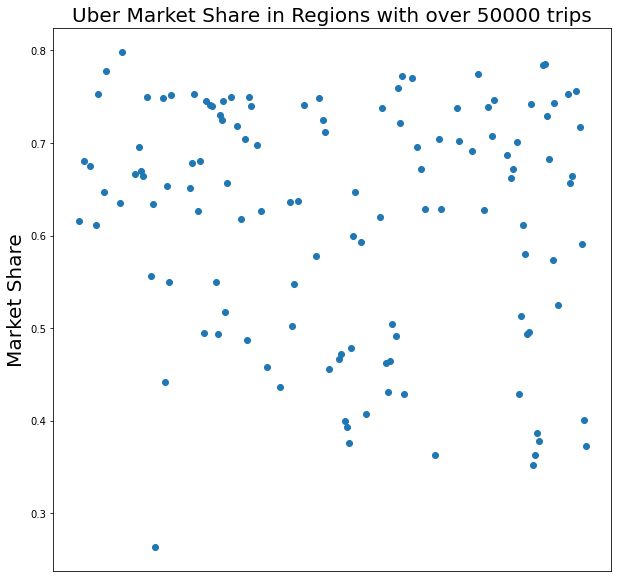

In [73]:
f, ax = plt.subplots(1, figsize=(10, 10))
plt.plot(df_insight['Uber_share'], '.', markersize=12)
ax.axes.xaxis.set_visible(False)
ax.set_title('Uber Market Share in Regions with over 50000 trips', fontsize=20)
plt.ylabel('Market Share', fontsize=20)
# plt.savefig("uber_market_share_july.png", dpi=300)
# plt.clf()

As we can see, we should offer discount in areas like zone 43

In [38]:
# zone 43 market share
rides_num = dict()
for comp, cur_ser in count_byPU_dict.items():
    if 43 in cur_ser.index:
        rides_num[comp] = cur_ser[43]
    else:
        rides_num[comp] = 0
rides_num

{'via': 236,
 'lyft': 5955,
 'juno': 0,
 'uber': 18970,
 'yellow': 45440,
 'green': 1236}

Text(0.5, 1.0, 'Market Share for Rides Picked Up at Central Park')

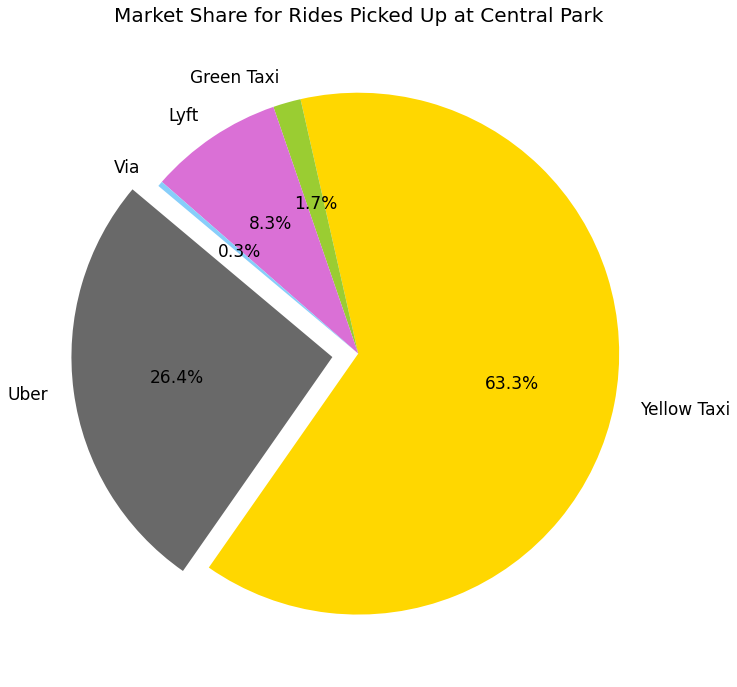

In [82]:
# finally we plot the market share pie chart
labels = ('Uber', 'Yellow Taxi', 'Green Taxi', 'Lyft', 'Via')
sizes = [18970, 45440, 1236, 5955, 236]
colors = ['dimgrey', 'gold', 'yellowgreen', 'orchid', 'lightskyblue']
explode = (0.1, 0, 0, 0, 0)  # explode 1st slice

# Plot
f, ax = plt.subplots(1, figsize=(12, 12))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, \
        autopct='%1.1f%%', shadow=False, startangle=140, textprops={'fontsize': 17})
ax.set_title('Market Share for Rides Picked Up at Central Park', fontsize=20)
# plt.savefig("uber_market_share_zone43.png", dpi=300)
# plt.clf()